# Figure 10.

Snapshot of top-of-atmosphere outgoing longwave radiation ($W~m^{-2}$) in the Proxima b simulation at 102 d: from the global model (a) over the whole planet, (b) zoomed in on the *HighRes* domain; and (c) from the *HighRes* simulation. The dark blue box in (a) shows the location of the *HighRes* domain. 

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Progress bar

In [2]:
from fastprogress import progress_bar

In [3]:
from datetime import datetime, timedelta

Scientific stack

In [4]:
import cartopy.crs as ccrs
import iris

import numpy as np

from matplotlib import gridspec
import matplotlib.pyplot as plt

In [5]:
from aeolus.coord_utils import UM_LATLON
from aeolus.core import Run
from aeolus.plot import GeoAxesGrid, label_global_map_gridlines
from aeolus.region import Region
from aeolus.util import fmt_lonlat, subplot_label_generator

Local modules

In [6]:
from commons import (
    DT_FMT,
    FCST_DIM_CNSTR,
    FCST_PRD_CNSTR,
    GLM_RUNID,
    NS_COLORS,
    NS_MODEL_TYPES,
    NS_RUN_ALIASES,
    NS_RUNID,
    PLANET_ALIASES,
)
import mypaths
from plot_func import use_style, CART_KW
from proc_um_output import process_cubes

Global stylesheet for figures.

In [7]:
use_style()

A few local definitions

In [8]:
planet = "proxb"
run_key = "grcs"

OUTPUT_NAME_PREFIX = f"{planet}_{run_key}"

Define the region to zoom in to in the figure.

In [9]:
ss_region = Region(-10, 30, -20, 20, "HighRes domain")

extent = [i["value"] for i in ss_region]

Set metadata for the variable.

In [10]:
varname = "toa_outgoing_longwave_flux"
short_name = "TOA OLR"
tex_units = "$W$ $m^{-2}$"
plt_kw = dict(cmap="Greys", vmin=60, vmax=270)

## Load data

Change file mask to load only the files with TOA radiation data.

In [11]:
NS_MODEL_TYPES["global"]["path"] = (
    NS_MODEL_TYPES["global"]["path"].parent / f"{GLM_RUNID}_pd*"
)
NS_MODEL_TYPES["lam"]["path"] = NS_MODEL_TYPES["lam"]["path"].parent / f"{NS_RUNID}_pa*"

Create a dictionary of `Run` objects with UM data.

In [12]:
runs = {}
for model_type, model_specs in progress_bar(NS_MODEL_TYPES.items()):
    subdir = f"{planet}_{run_key}"
    label = f"{planet}_{run_key}_{model_type}"
    fpath = mypaths.nsdir / subdir / "*" / model_specs["path"]
    # Load data
    run = Run(
        files=fpath,
        name=label,
        planet=planet,
        model_type=model_type,
        timestep=model_specs["timestep"],
    )
    # Regrid & interpolate data
    run.proc_data(
        process_cubes,
        timestep=run.timestep,
        extract_mean=False,
        regrid_multi_lev=False,
    )
    # Select domain
    run.proc = run.proc.extract(FCST_PRD_CNSTR)
    # Save to dict
    runs[label] = run

Extract cubes of TOA OLR along with longitude and latitude from the global and HighRes simulations.

In [13]:
cubes = {}
lats = {}
lons = {}
for model_type in NS_MODEL_TYPES.keys():
    cubes[model_type] = runs[f"{planet}_{run_key}_{model_type}"].proc.extract_strict(varname)
    lats[model_type] = cubes[model_type].coord(UM_LATLON[0]).points
    lons[model_type] = cubes[model_type].coord(UM_LATLON[1]).points

Choose the time slice.

In [14]:
hour0 = cubes["lam"].coord("time").points[0]

In [15]:
FCST_TIME_CNSTR = iris.Constraint(
    forecast_reference_time=lambda x: (x.point.day == 26) & (x.point.month == 7)
)  # 100 days

In [16]:
ndays = (
    cubes["lam"].extract(FCST_TIME_CNSTR).coord("time").points[0]
    - hour0
) / 24
ndays

100.0

## Plot the results

Set axes tick locations.

In [17]:
xlocs_ss = np.arange(-20, 50, 10)
ylocs_ss = np.arange(-30, 40, 10)

xlocs = np.arange(-180, 181, 60)
ylocs = np.arange(-90, 91, 30)

Set title styles.

In [18]:
ttl_kw = dict(fontsize="small", pad=5, loc="left")
cb_ttl_kw = dict(fontsize="x-small", pad=5)

Assemble the plot.

In [19]:
ncols = 3
nrows = 1
iletters = subplot_label_generator()

fig = plt.figure(figsize=(ncols * 8, nrows * 6),)

gs = gridspec.GridSpec(1, 4)
axs = []

model_type = "global"
ax = fig.add_subplot(gs[:2], projection=ccrs.Robinson())
axs.append(ax)
ax.pcolormesh(
    lons[model_type],
    lats[model_type],
    cubes[model_type].extract(FCST_TIME_CNSTR).data,
    **plt_kw,
    **CART_KW,
)
ss_region.add_to_ax(
    ax, edgecolor=NS_COLORS[run_key]["lam"], facecolor="none", linewidth=5, **CART_KW
)
label_global_map_gridlines(
    fig, ax, xlocs[1:-1], ylocs[1:-1], degree=True, size="x-small", xoff=-15
)
ax.gridlines(xlocs=xlocs, ylocs=ylocs, crs=ccrs.PlateCarree())
ax.set_title(
    f"{NS_MODEL_TYPES[model_type]['title']} model, full domain ({PLANET_ALIASES[planet]})",
    fontsize="medium",
    pad=5,
    loc="center",
)

ax = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
axs.append(ax)
ax.pcolormesh(
    lons[model_type],
    lats[model_type],
    cubes[model_type].extract(FCST_TIME_CNSTR).data,
    **plt_kw,
    **CART_KW,
)
ax.set_title(
    f"{NS_MODEL_TYPES[model_type]['title']} model, zoomed in",
    fontsize="medium",
    pad=5,
    loc="center",
)

model_type = "lam"
ax = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
axs.append(ax)
h = ax.pcolormesh(
    lons[model_type],
    lats[model_type],
    cubes[model_type].extract(FCST_TIME_CNSTR).data,
    **plt_kw,
    **CART_KW,
)
ax.set_title(
    f"{NS_MODEL_TYPES[model_type]['title']} model",
    fontsize="medium",
    pad=5,
    loc="center",
)

for ax in fig.axes[1:]:
    ax.set_extent(extent)
    ax.gridlines(xlocs=xlocs_ss, ylocs=ylocs_ss, crs=ccrs.PlateCarree())
    label_global_map_gridlines(
        fig, ax, xlocs_ss[1:-1], ylocs_ss[1:-1], degree=True, size="x-small", xoff=-15
    )

for ax in fig.axes:
    ax.set_title(f"({next(iletters)})", **ttl_kw)

cb = fig.colorbar(h, ax=axs, orientation="vertical", shrink=0.82, pad=0.02)
cb.ax.set_ylabel(f"{short_name} [{tex_units}]")
plt.close()  # Show the figure in a separate cell

## Show the figure

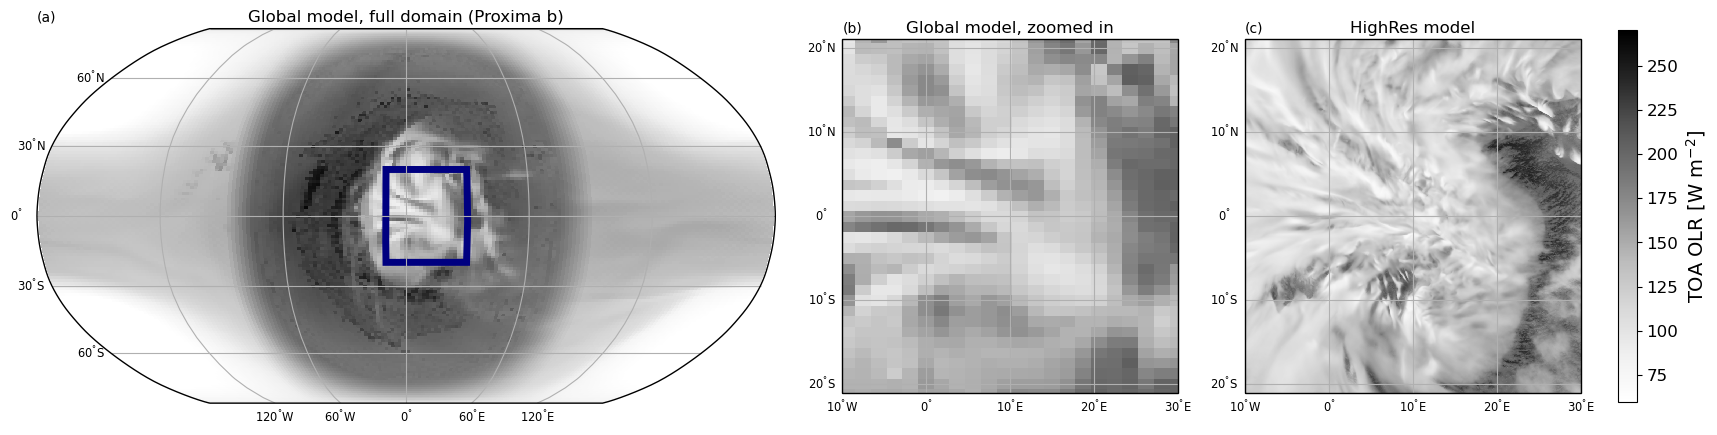

In [20]:
fig

And save it.

In [21]:
imgname = mypaths.plotdir / f"{planet}__{run_key}__toa_olr_map__{ndays:.0f}d.png"

In [22]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/proxb__grcs__toa_olr_map__100d.png
